**We will start by importing frameworks and libraries.**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from plotly.offline import iplot, init_notebook_mode

**Now we will load the csv and take a quick at the first rows...**

In [2]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


**It´s an intuitive thought to believe that the Reading writing scores will be more alike than the math scores. Calling df.describe() we can check out that thought…**

In [3]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


**We can see that only three columns are numerical, the rest of them will likely need to be preprocessed. We will define a function to take care of all the encoding part.**

In [0]:
def encode(dataframe, column):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    values = np.array(dataframe[column])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    list_onehot = []
    for i in range(onehot_encoded.shape[1]):
        list_onehot.append(column+str(i))

    df1 = pd.DataFrame(onehot_encoded, columns = list_onehot)

    dataframe [list_onehot] = df1 [list_onehot]

    return dataframe

**Of all the columns, we only want to encode the first five…**

In [5]:
column_list = df.columns.tolist()
columns_to_encode = column_list[:5]
column_list

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course',
 'math score',
 'reading score',
 'writing score']

In [6]:
for column in columns_to_encode:
    encode(df, column)

df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncod

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender0,gender1,race/ethnicity0,race/ethnicity1,race/ethnicity2,race/ethnicity3,race/ethnicity4,parental level of education0,parental level of education1,parental level of education2,parental level of education3,parental level of education4,parental level of education5,lunch0,lunch1,test preparation course0,test preparation course1
0,female,group B,bachelor's degree,standard,none,72,72,74,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,female,group C,some college,standard,completed,69,90,88,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,female,group B,master's degree,standard,none,90,95,93,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,male,group A,associate's degree,free/reduced,none,47,57,44,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,male,group C,some college,standard,none,76,78,75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


**This few lines of code are just intended to reorder the columns keeping the encoded ones and placing the scores at the end.**

In [0]:
column_list = df.columns.tolist()

reverse_column_list = column_list[::-1]
column_list = reverse_column_list[:-5]

last_columns = column_list[-3:]

column_list = column_list[:-3]
column_list = column_list[::-1]

In [8]:
for column in last_columns:
    column_list.append(column)

column_list

['gender0',
 'gender1',
 'race/ethnicity0',
 'race/ethnicity1',
 'race/ethnicity2',
 'race/ethnicity3',
 'race/ethnicity4',
 'parental level of education0',
 'parental level of education1',
 'parental level of education2',
 'parental level of education3',
 'parental level of education4',
 'parental level of education5',
 'lunch0',
 'lunch1',
 'test preparation course0',
 'test preparation course1',
 'writing score',
 'reading score',
 'math score']

**Now we will define the list of columns that we will normalize (the columns containing the scores).**<br>
**We will define a dictionary with the max values for each column, and redefine the data frame with normalized columns.**

In [9]:
df = df[column_list]
list_to_norm = df.columns.tolist()
list_to_norm = list_to_norm[-3:]
list_to_norm

['writing score', 'reading score', 'math score']

In [10]:
dict_max = {}

for i in list_to_norm:
    dict_max[i] = df[i].abs().max()
  
for i in list_to_norm:
    df[i] = df[i]/dict_max[i]

df.head()

,gender0,gender1,race/ethnicity0,race/ethnicity1,race/ethnicity2,race/ethnicity3,race/ethnicity4,parental level of education0,parental level of education1,parental level of education2,parental level of education3,parental level of education4,parental level of education5,lunch0,lunch1,test preparation course0,test preparation course1,writing score,reading score,math score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.74,0.72,0.72
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.88,0.90,0.69
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.93,0.95,0.90
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.44,0.57,0.47
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.75,0.78,0.76


**We are going to plot the correlation (absolute value) using Seaborn with a heat map style.**

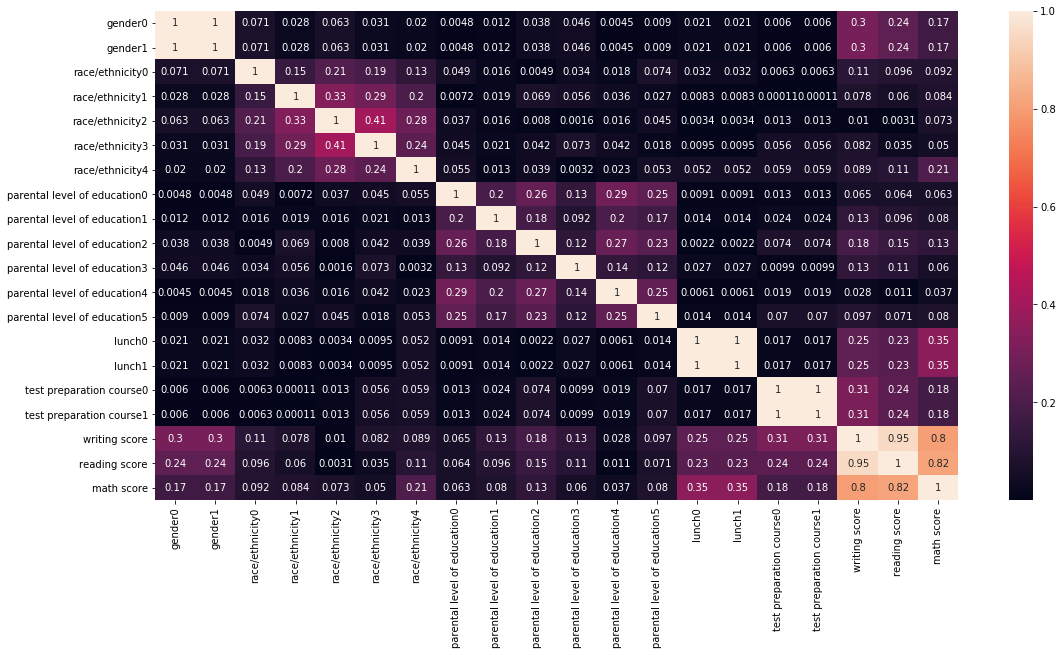

In [11]:
%matplotlib inline

plt.figure(figsize=(18, 9)) 
corr = df.corr()
corr = abs(corr)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

**We want to remove the features with low correlation. We will set the bar at 0.1**

In [0]:
new_col_list = corr['math score'][corr['math score']>0.1]

**We are about to randomize the set, but before doing that, we will remove the last column (math score) because that is what we want to predict.**

In [13]:
new_col_list = new_col_list.index.tolist()
new_col_list = new_col_list[:(len(new_col_list)-1)]
new_col_list

['gender0',
 'gender1',
 'race/ethnicity4',
 'parental level of education2',
 'lunch0',
 'lunch1',
 'test preparation course0',
 'test preparation course1',
 'writing score',
 'reading score']

**Now we are ready to randomize, first we create the randomized index lists.**

*   Training size: 70%
*   Validation size: 15%
*   Test: 15%





In [0]:
index_list = df.index.tolist()

random_index_list = np.random.RandomState(0).choice(index_list, len(index_list), replace=False).tolist()

train_total = int(len(index_list)*0.7)
train_index_list = random_index_list[:train_total]

validation_total = int(len(index_list)*0.15)
validation_index_list = random_index_list[train_total:(train_total + validation_total)]

test_index_list = random_index_list[(train_total + validation_total):]

**All we are doing here is creating the training, validation and test sets according to their index lists.**

In [0]:
train_df = df.iloc[train_index_list]
validation_df = df.iloc[validation_index_list]
test_df = df.iloc[test_index_list]

**We are going to use here the list of columns we defined previously to remove the column containing the math score (that will be our ‘y’)**

In [0]:
train_set = train_df[new_col_list]
validation_set = validation_df[new_col_list]
test_set = test_df[new_col_list]

**Now we are all ready to define our X’s and y’s for training, validation and test sets.**

In [0]:
X_train = train_set

y_train = df['math score'][train_index_list]

In [0]:
X_val = validation_set

y_val = df['math score'][validation_index_list]

In [0]:
X_test = test_set

y_test = df['math score'][test_index_list]

**This is only to double check the size of our training, validation and test sets.**

In [20]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))
print(X_test.shape, len(y_test))

(700, 10) 700
(150, 10) 150
(150, 10) 150


**We are finaly ready to define our Sequential model:**

*   Input Layer: 10 Neurons
*   2 Hiden Layers: 16 Neurons
*   Activation functions: Relu
*   Output Layer: 1 Neuron (Regression)
*   Batch normalization after each hidden layer



In [21]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, 
                              activation = 'relu', 
                              input_shape = (X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1)
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 593
Trainable params: 529
Non-trainable params: 64
_________________________________________________________________


**We will use the following hyperparameters:**

*   Bath size: 12
*   Epochs: 400
*   Loss: Mean squared error
*   Optimizer: Adam
*   Metrics: Mean absolute error



In [22]:
batch_size = 12
epochs = 400

# Definition of the settings
model.compile(loss='mse',
              #optimizer = tf.keras.optimizers.RMSprop(lr=1e-4),
              #optimizer = tf.keras.optimizers.RMSprop(0.001),
              optimizer='adam',
              metrics=['mae'])

# Training of the network
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=1)

test_loss, test_mae = model.evaluate(X_test, y_test)

print('Test loss (mse):', test_loss)
print('Test mean absolute error:', test_mae)

Train on 700 samples, validate on 150 samples
Epoch 1/400
700/700 [==============================] - 0s 599us/sample - loss: 1.4229 - mean_absolute_error: 0.9289 - val_loss: 0.1335 - val_mean_absolute_error: 0.3007
Epoch 2/400
700/700 [==============================] - 0s 201us/sample - loss: 0.3737 - mean_absolute_error: 0.4796 - val_loss: 0.1711 - val_mean_absolute_error: 0.3558
Epoch 3/400
700/700 [==============================] - 0s 178us/sample - loss: 0.2475 - mean_absolute_error: 0.3782 - val_loss: 0.1632 - val_mean_absolute_error: 0.3441
Epoch 4/400
700/700 [==============================] - 0s 183us/sample - loss: 0.1812 - mean_absolute_error: 0.3228 - val_loss: 0.1361 - val_mean_absolute_error: 0.3064
Epoch 5/400
700/700 [==============================] - 0s 188us/sample - loss: 0.1360 - mean_absolute_error: 0.2829 - val_loss: 0.1124 - val_mean_absolute_error: 0.2776
Epoch 6/400
700/700 [==============================] - 0s 160us/sample - loss: 0.1390 - mean_absolute_error: 

**As we can see, the Mean Squared Error is 0.0027 and the Mean Absolute Error is 0.043. Let’s plot their evolution with each Epoch.**

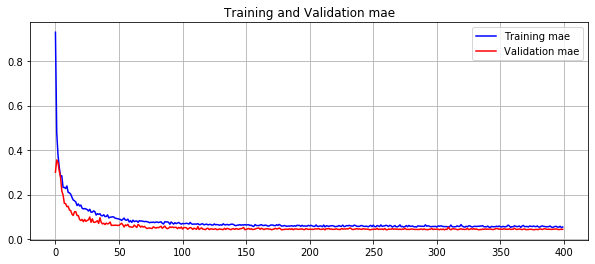

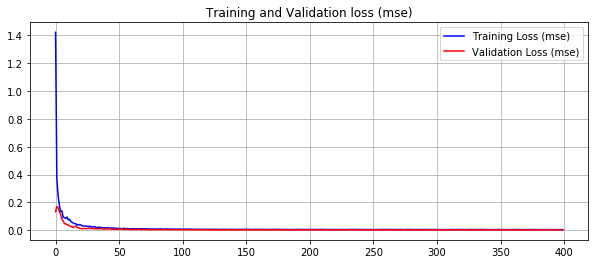

In [23]:
import matplotlib.pyplot as plt
mae1 = history.history['mean_absolute_error']
val_mae1 = history.history['val_mean_absolute_error']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs1 = range(len(mae1))

plt.figure(figsize=(10, 4))

plt.plot(epochs1, mae1, 'b', label='Training mae')
plt.plot(epochs1, val_mae1, 'r', label='Validation mae')
plt.title('Training and Validation mae')
plt.grid()
plt.legend()

plt.figure(figsize=(10, 4))

plt.plot(epochs1, loss1, 'b', label='Training Loss (mse)')
plt.plot(epochs1, val_loss1, 'r', label='Validation Loss (mse)')
plt.title('Training and Validation loss (mse)')
plt.grid()
plt.legend()

plt.show()

**Thanks, and please let me know your thoughts and suggestions!**